<a href="https://colab.research.google.com/github/michaelhow/GraphicalModel/blob/master/AgencyPrepay_FNMA_30Yr_snowflake.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Initialize

Since the mortgage agencies have their own criteria to underwrite and pool their mortgages, their prepayment behaviors are not necessarily the same. For example:

• the GNMA mortgage pools, which are either insured by FHA or guaranteed by VA loans, qualify only low income households and veterans. As a result their prepayments can behave quite different from the conventional loans which are originated by FNMA or FHLMC.

• Amortization based on diverse loan amortization schedules and maturity terms such as 30-year, 15-year, 7-year balloon, and 5-year balloon have different prepayment rates.

• Payment types such as fixed rate, adjustable rate, or GPM can also result in different types of prepayments. 

• Prepayment structures can be demographically different and should be estimated separately. 

This model only focuses on the 30-year conventional fixed rate residential mortgages underwritten by FNMA. Our modeling approach is to apply deep learning techniques.

In [1]:
!pip install cffi==1.12
!pip install fredapi
!pip install Quandl
!pip install QuantLib
!pip install snowflake-connector-python
from fredapi import Fred
fred = Fred('d370a2a2ac12326058de806208b9e6f5')
import quandl
quandl.ApiConfig.api_key = '4_xehrB5TxEE9FseBc9s'
import numpy as np
import pandas as pd
from sklearn import preprocessing
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import TimeSeriesSplit
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt
import snowflake.connector
import decimal
import time

# Declare Pool and Graph settings

In [0]:
plt.rcParams['figure.figsize'] = (9, 5)
plt.rc('legend',fontsize='medium')
scaler = preprocessing.StandardScaler()
EWMA_Input=6
EWMA_Resp=6
end_date =  '2019-01-31'

# Initialize Snowflake

In [3]:
ctx = snowflake.connector.connect(
    user='PoolModeling',
    password='3@kjsay#5',
    account='ax31757.us-east-1',
    warehouse='XS',
    database='POC',
    schema='EMBS'
    )
cs = ctx.cursor()
try:
    cs.execute("select top 4 CUSIP from histn;")
    one_row = cs.fetchone()
    print(one_row[0])
finally:
    cs.close()

#conn_info={'host': '192.168.10.208',
#                            'port': '5433',
#                            'user': 'dbadmin',
#                            'password': 'vichara111'
#                            }

31406PZU6


## FRED State Level Economic Data

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


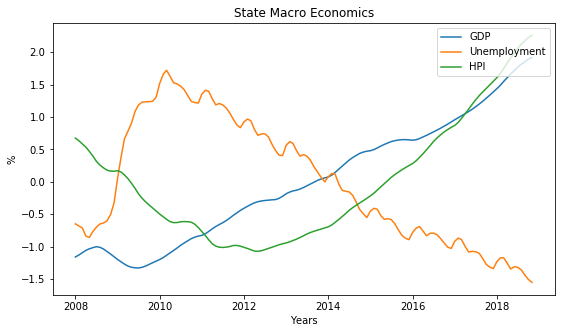

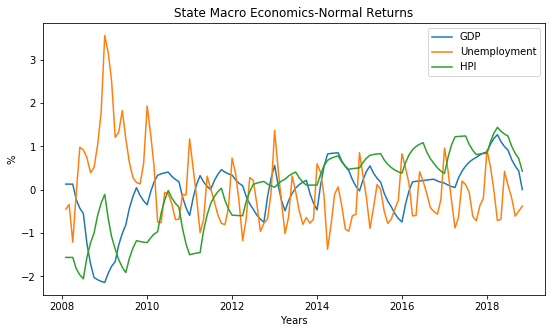

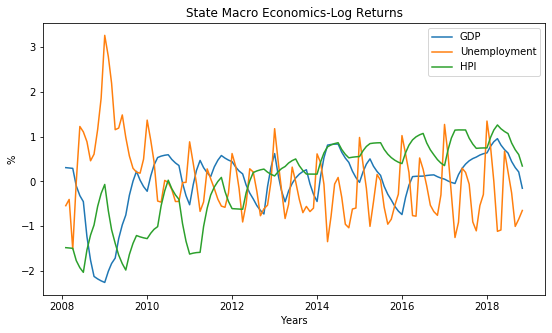

In [5]:
State_id={'AK','AL','AR','AZ','CA','CO','CT','DC','DE','FL','GA','HI','IA','ID','IL','IN','KS','KY','LA','MA','MD','ME','MI','MN','MO','MS','MT','NC','ND','NE','NH','NJ','NM','NV','NY','OH','OK','OR','PA','RI','SC','SD','TN','TX','UT','VA','VT','WA','WI','WV','WY'}

dict_state_GDP = {}
dict_state_Unemp = {}
dict_state_HPI = {}

for item in State_id:
    dict_state_GDP[item] = fred.get_series(item+'NQGSP', observation_start='2008-01-01', observation_end='2018-11-30')
    dict_state_Unemp[item] = fred.get_series(item+'URN', observation_start='2008-01-01', observation_end='2018-11-30')
    dict_state_HPI[item] = fred.get_series(item+'STHPI', observation_start='2008-01-01', observation_end='2018-11-30')
    time.sleep(1)

df_state_GDP=pd.DataFrame(dict_state_GDP)
ser_state_GDP_stack=df_state_GDP.stack()
df_state_GDP_stack=ser_state_GDP_stack.to_frame()
df_state_GDP_stack.columns = ['State_GDP']

df_state_Unemp=pd.DataFrame(dict_state_Unemp)
ser_state_Unemp_stack=df_state_Unemp.stack()
df_state_Unemp_stack=ser_state_Unemp_stack.to_frame()
df_state_Unemp_stack.columns = ['State_Unemp']


df_state_HPI=pd.DataFrame(dict_state_HPI)
ser_state_HPI_stack=df_state_HPI.stack()
df_state_HPI_stack=ser_state_HPI_stack.to_frame()
df_state_HPI_stack.columns = ['State_HPI']

#variables
df_state_econ=pd.concat([df_state_GDP_stack, df_state_Unemp_stack, df_state_HPI_stack],axis=1, join='outer')
df_state_econ.reset_index(inplace=True)
df_state_econ=df_state_econ.rename(columns={'level_0':'EffDt','level_1':'State'})
df_state_econ.index = df_state_econ['EffDt']
df_state_econ=df_state_econ.drop(['EffDt'],axis=1)
df_state_econ_clean=df_state_econ.groupby('State').transform(lambda x: x.interpolate(method='linear',limit_direction='both'))
df_state_econ_clean.insert(loc=0, column='State', value=df_state_econ['State'].values)
df_state_econ_smooth = df_state_econ_clean.groupby(['State']).transform(lambda x: x.ewm(span=EWMA_Input).mean())
df_state_econ_smooth.insert(loc=0, column='State', value=df_state_econ['State'].values)
df_state_econ_std=df_state_econ_smooth.groupby('State').transform(lambda x: (x - x.mean()) / x.std())
df_state_econ_std.insert(loc=0, column='State', value=df_state_econ['State'].values)
df_state_econ_std_summary=df_state_econ_std.groupby('EffDt').mean()

fig = plt.figure() 
plt.plot(df_state_econ_std_summary['State_GDP'], label='GDP')
plt.plot(df_state_econ_std_summary['State_Unemp'], label='Unemployment')
plt.plot(df_state_econ_std_summary['State_HPI'], label='HPI')
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.title("State Macro Economics")
plt.savefig('MacroEconomics_State')
plt.show()
plt.close(fig) 

#rtns
df_state_econ_rtn=df_state_econ_clean.groupby('State').transform(lambda x: x.diff())
df_state_econ_rtn=df_state_econ_rtn.rename(columns={'State_GDP':'State_GDP_rtn','State_Unemp':'State_Unemp_rtn','State_HPI':'State_HPI_rtn'})
df_state_econ_rtn.insert(loc=0, column='State', value=df_state_econ['State'].values)
df_state_econ_rtn=df_state_econ_rtn.dropna()
df_state_econ_rtn_smooth = df_state_econ_rtn.groupby(['State']).transform(lambda x: x.ewm(span=EWMA_Input).mean())
df_state_econ_rtn_smooth.insert(loc=0, column='State', value=df_state_econ_rtn['State'].values)
df_state_econ_rtn_std=df_state_econ_rtn_smooth.groupby('State').transform(lambda x: (x - x.mean()) / x.std())
df_state_econ_rtn_std.insert(loc=0, column='State', value=df_state_econ_rtn['State'].values)
df_state_econ_rtn_std_summary=df_state_econ_rtn_std.groupby('EffDt').mean()

fig = plt.figure() 
plt.plot(df_state_econ_rtn_std_summary['State_GDP_rtn'], label='GDP')
plt.plot(df_state_econ_rtn_std_summary['State_Unemp_rtn'], label='Unemployment')
plt.plot(df_state_econ_rtn_std_summary['State_HPI_rtn'], label='HPI')
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.title("State Macro Economics-Normal Returns")
plt.savefig('MacroEconomics_State_rtns')
plt.show()
plt.close(fig) 

#log rtns
df_state_econ_logrtn=df_state_econ_clean.groupby('State').transform(lambda x: np.log(x).diff())
df_state_econ_logrtn=df_state_econ_logrtn.rename(columns={'State_GDP':'State_GDP_logrtn','State_Unemp':'State_Unemp_logrtn','State_HPI':'State_HPI_logrtn'})
df_state_econ_logrtn.insert(loc=0, column='State', value=df_state_econ['State'].values)
df_state_econ_logrtn=df_state_econ_logrtn.dropna()
df_state_econ_logrtn_smooth = df_state_econ_logrtn.groupby(['State']).transform(lambda x: x.ewm(span=EWMA_Input).mean())
df_state_econ_logrtn_smooth.insert(loc=0, column='State', value=df_state_econ_rtn['State'].values)
df_state_econ_logrtn_std=df_state_econ_logrtn_smooth.groupby('State').transform(lambda x: (x - x.mean()) / x.std())
df_state_econ_logrtn_std.insert(loc=0, column='State', value=df_state_econ_rtn['State'].values)
df_state_econ_logrtn_std_summary=df_state_econ_logrtn_std.groupby('EffDt').mean()

fig = plt.figure() 
plt.plot(df_state_econ_logrtn_std_summary['State_GDP_logrtn'], label='GDP')
plt.plot(df_state_econ_logrtn_std_summary['State_Unemp_logrtn'], label='Unemployment')
plt.plot(df_state_econ_logrtn_std_summary['State_HPI_logrtn'], label='HPI')
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.title("State Macro Economics-Log Returns")
plt.savefig('MacroEconomics_State_logrtns')
plt.show()
plt.close(fig) 

# Get Economic data from FRED

In [0]:
#monthy and quarterly
list_m = {}
list_m['Real GDP'] = fred.get_series('ND000334Q', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['HPI_FHFA'] = fred.get_series('USSTHPI', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['Delinq_RealEstateLoans'] = fred.get_series('DRSFRMACBN', observation_start='2008-01-01', observation_end='2018-12-30')
list_m['Rent'] = fred.get_series('CUUR0000SEHA', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['CPI'] = fred.get_series('CPIAUCNS', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['Fed Funds'] = fred.get_series('FEDFUNDS', observation_start='2008-01-01', observation_end='2018-11-30')
time.sleep(1)
list_m['CMT_10Yr'] = fred.get_series('GS10', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['CMT_2Yr'] = fred.get_series('GS2', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['Housing Supply'] = fred.get_series('MSACSRNSA', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['Unemployment Rate'] = fred.get_series('UNRATENSA', observation_start='2008-01-01', observation_end='2018-11-30')
list_m['Mort_15Yr'] = fred.get_series('MORTGAGE15US', observation_start='2008-01-01', observation_end='2018-11-30',frequency='m')
list_m['Mort_30Yr'] = fred.get_series('MORTGAGE30US', observation_start='2008-01-01', observation_end='2018-11-30',frequency='m')
list_m['Libor_3m'] = fred.get_series('USD3MTD156N', observation_start='2008-08-01', observation_end='2018-11-30',frequency='m')
df_econ=pd.DataFrame(list_m)
df_econ=df_econ.interpolate(method='linear',limit_direction='both')
df_econ=df_econ.reset_index()
df_econ=df_econ.rename(columns={'index':'EffDt'})

# Get data from Quandl

In [0]:
data_fhmi = quandl.get('NAHB/NWFHMI').reset_index()
data_fhmi=data_fhmi.rename(columns={'Value':'FHMI'})
data_fhmi.Month=data_fhmi.Month + pd.offsets.MonthBegin(1)

data_confid = quandl.get('YALE/US_CONF_INDEX_1YR_INDIV').reset_index()
data_confid=data_confid.rename(columns={'Index Value':'Confid_1Yr','Standard Error':'Confid_SE'})
data_confid.Date=data_confid.Date + pd.offsets.MonthBegin(1)

# Combine FRED and Quandl data

In [0]:
df_econ=df_econ.merge(data_fhmi,left_on='EffDt',right_on='Month',how='inner')
df_econ=df_econ.merge(data_confid,left_on='EffDt',right_on='Date',how='inner')
df_econ.index = df_econ['EffDt']
df_econ=df_econ.drop(['EffDt','Month','Date'],axis=1)
names = df_econ.columns

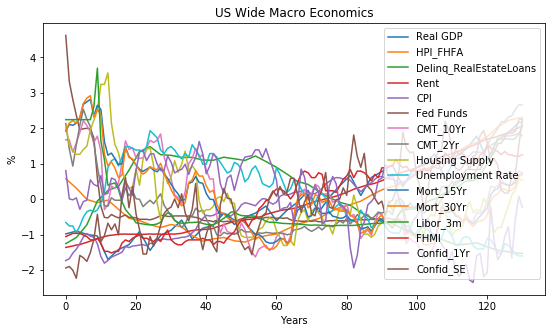

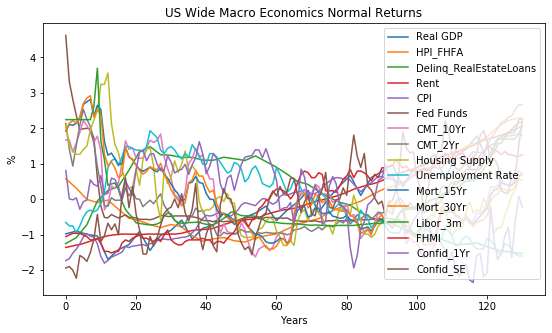

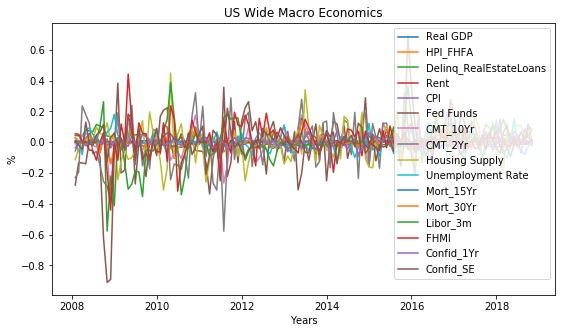

In [9]:
df_econ_std=scaler.fit_transform(df_econ)
df_econ_std=pd.DataFrame(df_econ_std,columns=df_econ.columns)

fig = plt.figure() 
plt.plot(df_econ_std)
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(df_econ.columns,loc='upper right')
plt.title('US Wide Macro Economics')
plt.savefig('MacroEconomics_US')
plt.show()
plt.close(fig)
#==============================================================================
#Economic Data (normal rtns)
# =============================================================================
df_econ_rtn=df_econ.diff().dropna()
df_econ_rtn_std=scaler.fit_transform(df_econ_rtn)
df_econ_rtn_std=pd.DataFrame(df_econ_rtn_std,columns=df_econ.columns)

fig = plt.figure() 
plt.plot(df_econ_std)
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(df_econ.columns,loc='upper right')
plt.title('US Wide Macro Economics Normal Returns')
plt.savefig('MacroEconomics_US_Returns')
plt.show()
plt.close(fig)
#==============================================================================
#Economic Data (log-normal rtns)
# =============================================================================
df_econ_logrtn=np.log(df_econ).diff().dropna()
df_econ_logrtn_std=scaler.fit_transform(df_econ_logrtn)
df_econ_logrtn_std=pd.DataFrame(df_econ_logrtn_std,columns=df_econ.columns)

fig = plt.figure() 
plt.plot(df_econ_logrtn)
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(df_econ.columns,loc='upper right')
plt.title('US Wide Macro Economics')
plt.savefig('MacroEconomics_US_Log returns')
plt.show()
plt.close(fig)

## Apply Principal Component Analysis to Economic Data ( Data, normal returns and log-normal returns)

Once we have selected the variables we apply Principal Component Analysis (PCA). PCA is a mathematical procedure that transforms a number of (possibly) correlated variables into a (smaller) number of uncorrelated variables called principal components. The first principal component accounts for as much of the variability in the data as possible, and each succeeding component accounts for as much of the remaining variability as possible. To explain further, say we have ten independent variables. We will create N “new” independent variables, where each “new” independent variable is a combination of each of the N “old” independent variables. However, we create these new independent variables in a specific way and order these new variables by how well they predict our dependent variable. We will then keep as many of the new independent variables as we want, but we drop the “least important ones.” Because we ordered the new variables by how well they predict our dependent variable, we know which variable is the most important and least important. However, these new independent variables are combinations of our old ones, so are still keeping the most valuable parts of our old variables. As an added benefit, each of the “new” variables after PCA are all independent of one another. The summary of our approach is as follows

• standardize the data.

• obtain the eigenvectors and eigenvalues from the covariance matrix or correlation matrix,.

• sort eigenvalues in descending order 

• choose k eigenvectors that correspond to thek largest eigenvalues, where k is the number of dimensions of the new feature subspace (k\le d). 

• construct a projection matrix W from the selected k eigenvectors. 

• Transform the original dataset X via W to obtain a k- dimensional feature subspace Y.

99.30%


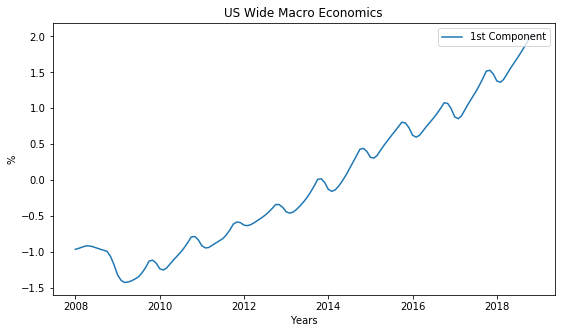

98.63%


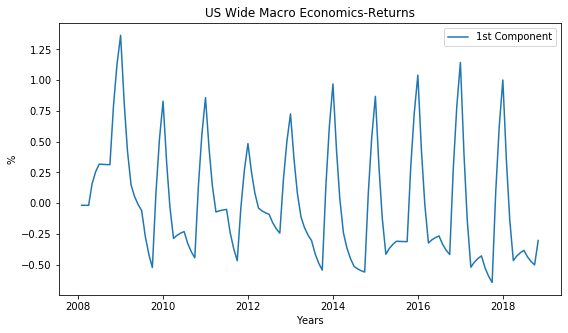

[0.38559152 0.20333724 0.12094676 0.0999577  0.08027529 0.04248494]
93.26%


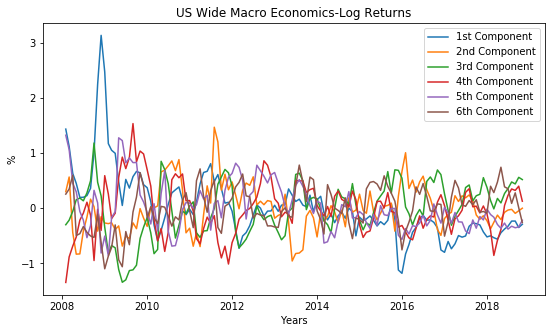

In [10]:
pca = PCA(n_components=1)
columns_pca = ['1st Component']
pca.fit(df_econ)
df_econ_pca = pca.transform(df_econ)
df_econ_pca=pd.DataFrame(df_econ_pca,columns=columns_pca)
df_econ_pca_std=scaler.fit_transform(df_econ_pca)
df_econ_pca_std=pd.DataFrame(df_econ_pca_std, columns=columns_pca)
df_econ_pca_std.index=df_econ.index
df_econ_pca_std = df_econ_pca_std.ewm(span=EWMA_Input).mean()
eigenvec=pca.components_
eigenval=pca.explained_variance_
eigenvalratio=pca.explained_variance_ratio_
np.savetxt('eigenvec',eigenvec, delimiter=",")
np.savetxt('eigenval',eigenval, delimiter=",")
np.savetxt('eigenvalratio',eigenvalratio, delimiter=",")

print("%.2f%%" % (eigenvalratio*100))

fig = plt.figure() 
plt.plot(df_econ_pca_std['1st Component'], label='1st Component')
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.title('US Wide Macro Economics')
plt.savefig('MacroEconomics_US_PCA')
plt.show()
plt.close(fig)
#==============================================================================
# Apply PCA to Economic Data (normal rtns)
# =============================================================================
pca_rtn = PCA(n_components=1)
columns_pca_rtn = ['1st Component_rtn']
pca_rtn.fit(df_econ_rtn)
df_econ_rtn_pca = pca_rtn.transform(df_econ_rtn)
df_econ_rtn_pca=pd.DataFrame(df_econ_rtn_pca,columns=columns_pca_rtn)
df_econ_rtn_pca_std=scaler.fit_transform(df_econ_rtn_pca)
df_econ_rtn_pca_std=pd.DataFrame(df_econ_rtn_pca_std, columns=columns_pca_rtn)
df_econ_rtn_pca_std.index=df_econ_rtn.index
df_econ_rtn_pca_std = df_econ_rtn_pca_std.ewm(span=EWMA_Input).mean()
eigenvec_rtn=pca_rtn.components_
eigenval_rtn=pca_rtn.explained_variance_
eigenvalratio_rtn=pca_rtn.explained_variance_ratio_
np.savetxt('eigenvec',eigenvec_rtn, delimiter=",")
np.savetxt('eigenval',eigenval_rtn, delimiter=",")
np.savetxt('eigenvalratio',eigenvalratio_rtn, delimiter=",")


print ("%.2f%%" % (eigenvalratio_rtn*100))
fig = plt.figure() 
plt.plot(df_econ_rtn_pca_std['1st Component_rtn'], label='1st Component')
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.title('US Wide Macro Economics-Returns')
plt.savefig('MacroEconomics_US_rtn_PCA')
plt.show()
plt.close(fig)
#==============================================================================
# Apply PCA to Economic Data (log normal rtns)
# =============================================================================
pca_logrtn = PCA(n_components=6)
columns_pca_logrtn = ['1st Component_logrtn', '2nd Component_logrtn','3rd Component_logrtn','4th Component_logrtn', '5th Component_logrtn','6th Component_logrtn']
pca_logrtn.fit(df_econ_logrtn)
df_econ_logrtn_pca = pca_logrtn.transform(df_econ_logrtn)
df_econ_logrtn_pca=pd.DataFrame(df_econ_logrtn_pca,columns=columns_pca_logrtn)
df_econ_logrtn_pca_std=scaler.fit_transform(df_econ_logrtn_pca)
df_econ_logrtn_pca_std=pd.DataFrame(df_econ_logrtn_pca_std, columns=columns_pca_logrtn)
df_econ_logrtn_pca_std.index=df_econ_logrtn.index
df_econ_logrtn_pca_std = df_econ_logrtn_pca_std.ewm(span=EWMA_Input).mean()
eigenvec_logrtn=pca_logrtn.components_
eigenval_logrtn=pca_logrtn.explained_variance_
eigenvalratio_logrtn=pca_logrtn.explained_variance_ratio_
np.savetxt('eigenvec',eigenvec_logrtn, delimiter=",")
np.savetxt('eigenval',eigenval_logrtn, delimiter=",")
np.savetxt('eigenvalratio',eigenvalratio_logrtn, delimiter=",")

print (eigenvalratio_logrtn)
print ("%.2f%%" % (sum(eigenvalratio_logrtn)*100))
fig = plt.figure() 
plt.plot(df_econ_logrtn_pca_std['1st Component_logrtn'], label='1st Component')
plt.plot(df_econ_logrtn_pca_std['2nd Component_logrtn'], label='2nd Component')
plt.plot(df_econ_logrtn_pca_std['3rd Component_logrtn'], label='3rd Component')
plt.plot(df_econ_logrtn_pca_std['4th Component_logrtn'], label='4th Component')
plt.plot(df_econ_logrtn_pca_std['5th Component_logrtn'], label='5th Component')
plt.plot(df_econ_logrtn_pca_std['6th Component_logrtn'], label='6th Component')
plt.xlabel('Years')
plt.ylabel('%')
plt.legend(loc='upper right')
plt.title('US Wide Macro Economics-Log Returns')
plt.savefig('MacroEconomics_US_logrtn_PCA')
plt.show()
plt.close(fig)

## Select Pool Metrics

In [0]:
poolnum="%"
# =============================================================================
# Define categories
# =============================================================================

# =============================================================================
# Vintage
# =============================================================================
Vintage={
#'%',
'2010',
#'2011',
#'2012'',
#'2013',
#'2014',
#'2015',
 } 
# =============================================================================
# LTV
# =============================================================================
OLTV={
'All':['0','150'],
#'65':['0,'65'],
#'70':['65','70'],
#75':['70','75'],
#'80':['75','80'],
#'85':['80','85'],
#'90':['85','90'],
#'Over90':['60','97],
 } 
# =============================================================================
# WAC
# =============================================================================
Coupon={
#All':('1.00','10.00'),
#'Under375':('1.00','3.75'),        
#'40':('3.75','4.25'),
#'45':('4.25','4.75'),
'50':('4.75','5.25'),
#'55':('5.25','5.75'),
#'60':('5.75','6.25'),
#'Over625':('6.25','20.00'),
 } 
# =============================================================================
# % purchased
# =============================================================================
Purchase={
'All':('0','100.1'),        
#'50':('0','50'),
#'100':('50','100.1'),
 } 
# =============================================================================
# % Owned
# =============================================================================    
OwnerOcc={
'All':('0','100.1'),        
#'75':('0','75'),
#'100':('75','100.1'),
 } 
# =============================================================================
# % Single Unit
# ============================================================================= 
SingUnit={
'All':('0','100.1'),        
#'75':('0','75'),
#'100':('75','100.1'),
 }  

## Import Pool Metrics from EMBS

In [0]:
for Year in Vintage:
    for OLTV, ltv in OLTV.items(): 
        for Rate, cpn in Coupon.items(): 
            for Purch, purchperc in Purchase.items(): 
                for Owner, ownerperc in OwnerOcc.items():
                    for SingUnit, perc1unit in SingUnit.items(): 
                        # =============================================================================
                        # Get cpr history from EMBS
                        # =============================================================================
                        cs = ctx.cursor()
                        try:
                            SQL=('SELECT histn.EffDt as "EffDt",'
                            'Hist_CollSum2.Year as "Year",'
                            'Hist_CollSum2.PoolNumber as "PoolNum",'
                            'Hist_CollSum2.State as "State",'
                            'AVG(histn.Fctr) as "PoolFactor",'
                            'SUM(Hist_CollSum2.StLoans) as "StLoans",'
                            'AVG(Hist_CollSum2.WAOCS) as FICO,'
                            'AVG(Hist_CollSum2.PctPurch) as "Purch",'
                            'AVG(Hist_CollSum2.PctRefi) as "Refi",'
                            'AVG(Hist_CollSum2.Pct1Unit) as "SingleUnit",'
                            'AVG(Hist_CollSum2.Pct2_4Unit) as "MultiUnit",'
                            'AVG(Hist_CollSum2.PctOwnerOcc) as "OwnerOcc",'
                            'AVG(Hist_CollSum2.Pct2ndHome) as "SecondHome",'
                            'AVG(Hist_CollSum2.PctInvProp) as "InvProp",'
                            'AVG(Hist_CollSum2.WAOLTV) as WAOLTV,'
                            'AVG(histn.Wala) as "Wala", ' 
                            'AVG(histn.Wac) as "WAC", '
                            'AVG(histn.cprm) as "cpr" ' 
                            'FROM ( ( histn ' 
                            'INNER JOIN Hist_CollSum2 '
                            'ON histn.CUSIP = Hist_CollSum2.CUSIP)  ' 
                            'INNER JOIN Sec ' 
                            'ON histn.CUSIP = Sec.Cusip)  '
                            'WHERE Sec.Prefix = \'CL\'  '
                            'AND Hist_CollSum2.TotLoans >=  \'100\'  '
                            'AND Hist_CollSum2.PoolNumber Like \''+poolnum+'\' '
                            'AND Hist_CollSum2.Year Like \''+Year+'\' '
                            'AND Hist_CollSum2.WAOLTV > \''+ltv[0]+'\' '
                            'AND Hist_CollSum2.WAOLTV <= \''+ltv[1]+'\' '
                            'AND histn.Wac > \''+cpn[0]+'\' '
                            'AND histn.Wac <=  \''+cpn[1]+'\' '
                            'AND Hist_CollSum2.PctPurch > \''+purchperc[0]+'\' '
                            'AND Hist_CollSum2.PctPurch <=  \''+purchperc[1]+'\' '
                            'AND Hist_CollSum2.PctOwnerOcc > \''+ownerperc[0]+'\' '
                            'AND Hist_CollSum2.PctOwnerOcc <=  \''+ownerperc[1]+'\' '
                            'AND Hist_CollSum2.Pct1Unit > \''+perc1unit[0]+'\' '
                            'AND Hist_CollSum2.Pct1Unit <=  \''+perc1unit[1]+'\' '
                            'GROUP BY histn.EffDt,Hist_CollSum2.Year,Hist_CollSum2.PoolNumber,Hist_CollSum2.State ' 
                            'ORDER BY histn.EffDt,Hist_CollSum2.Year,Hist_CollSum2.PoolNumber,Hist_CollSum2.State'  )
                            cs.execute(SQL)
                            df_cpr_raw = pd.DataFrame.from_records(iter(cs), columns=[x[0] for x in cs.description])
                        finally:
                            cs.close()
ctx.close()

## Combine pool and economic data

In [13]:
                        print(len(df_cpr_raw))
                        df_all=df_cpr_raw.merge(df_econ,left_on='EffDt',right_on='EffDt',how='inner')
                        df_all=df_all.merge(df_state_econ_clean,left_on=['State','EffDt'],right_on=['State','EffDt'],how='inner')
                        df_all=df_all.drop_duplicates(subset=['EffDt','PoolNum', 'State'], keep=False).fillna(method='pad')
                        # =============================================================================
                        # Pool Statistics
                        # =============================================================================
                        df_PoolStats_1=df_all[['EffDt','PoolNum','State','PoolFactor']]
                        df_PoolStats_2=df_all[['WAOLTV','Purch','Refi','SingleUnit','MultiUnit','OwnerOcc','SecondHome','InvProp']].transform(lambda x: x/100)
                        df_PoolStats=pd.concat([df_PoolStats_1, df_PoolStats_2],axis=1, join='outer')
                        df_PoolStats.index = df_PoolStats['EffDt']
                        df_PoolStats=df_PoolStats.drop(['EffDt'],axis=1)
                        df_PoolStats=df_PoolStats.fillna(method='pad', axis=1)
                        df_PoolStats.to_csv('PoolStats')   

107980


## Calculate additional predictors

In [0]:
                        df_calcpredict = pd.DataFrame(columns=['EffDt','PoolNum','State','RefiInc','Burnout','Mort_30Yr'])
                        df_calcpredict['EffDt']=df_all['EffDt'].values
                        df_calcpredict['PoolNum']=df_all['PoolNum'].values
                        df_calcpredict['State']=df_all['State'].values
                        df_calcpredict['Mort_30Yr']= df_all['Mort_30Yr']/100
                        df_calcpredict['RPB'] = pd.to_numeric(df_all['WAOLTV'])*((1+df_all['WAC']/1200)**float(360)-(1+df_all['WAC']/1200)**pd.to_numeric(df_all['Wala']))/((1+df_all['WAC']/1200)**float(360)-1)
                        df_calcpredict['CurEq'] = df_all['State_HPI']*100/df_all['State_HPI'][0]-df_calcpredict['RPB']

# Calculate Burnout

The most common treatment is as follows:

 $Burnout=\sum_{t=1}^{j}max\left[log\left(\frac{C}{R_{t}}\right),0\right]$

where 

$𝐶$ = coupon (or contract) rate of a mortgage,
$𝑅_t$= prevailing interest rate available for refinancing at period $t$

The above equation has the following assumptions:

(1)The bigger the spread between coupon rate and prevailing interest rate, the stronger the incentive.

(2)The longer the period of rate drop cycle, the more likely a refinance will occur. 

In [0]:
                        df_calcpredict['Burnout']=np.log(df_all['WAC']/df_all['Mort_30Yr'])
                        df_calcpredict['Burnout']=df_calcpredict.groupby('PoolNum')['Burnout'].cumsum()
                        df_calcpredict.loc[df_calcpredict['Burnout'] <= 0, 'Burnout'] = 0.0001

# Calculate refinance incentive

By far, the most important factor that drives fixed-rate MBS prepayments is the ratio of current mortgage rates to the weighted-average gross coupon (GWAC) on the pool of mortgages. If a borrower has a higher interest rate than is available in the market, he will tend to refinance into the lower market rates, causing the prepayment speed of that pool to increase. The larger the difference between the rate held by the borrowers in the pool and the current market rate reference, the faster prepayment speeds become.The unit present value cost of changing from an existing loan rate of  $Cpn$  to a new loan rate  $Mkt$ , can be estimated as

The present value cost per dollar of changing from an existing loan rate of Cpn to a new loan rate Mkt, which we estimate as: 

$1−\frac{Cpn}{Mkt}\times\frac{1-\left(1+Mkt^{(\left(Term-Age\right)}\right)}{1-\left(1+Cpn^{Term}\right)}$


The amortized loan balance as a proportion of the likely amount of a new loan (that is, the amortized inflation-adjusted balance of the existing loan). We estimate this as

$\frac{\left(1+Cpn\right)^{Term}-\left(1+Cpn\right)^{Age}}{Hpi*\left[\left(1+Cpn\right)^{Term}-1\right]}$

 where $Cpn$ and $Mkt$ are expressed as monthly decimals, $Term$ is the original loan term, and $Age$ is the number of months since loan origination

In [0]:
                        df_calcpredict['RefiInc']=100*(df_all['WAC']/df_all['Mort_30Yr'])*(1-(1+df_all['Mort_30Yr']/1200)**(360-pd.to_numeric(df_all['Wala'])))/((1-(1+df_all['WAC']/1200)**(360-pd.to_numeric(df_all['Wala']))))

## Clean and process calculated predictors

In [0]:
                        df_calcpredict.index = df_calcpredict['EffDt']
                        del df_calcpredict['EffDt']
    
                        df_calcpredict_clean=df_calcpredict.fillna(method='pad')
                        df_calcpredict_std=df_calcpredict_clean.groupby(['PoolNum','State']).transform(lambda x: (x - x.mean()) / x.std())
                        df_calcpredict_std.insert(loc=0, column='State', value=df_calcpredict['State'].values)
                        df_calcpredict_std.insert(loc=0, column='PoolNum', value=df_calcpredict['PoolNum'].values)
                        df_calcpredict_std.to_csv('Calcpredict_std')

# Pre-process prepayment data

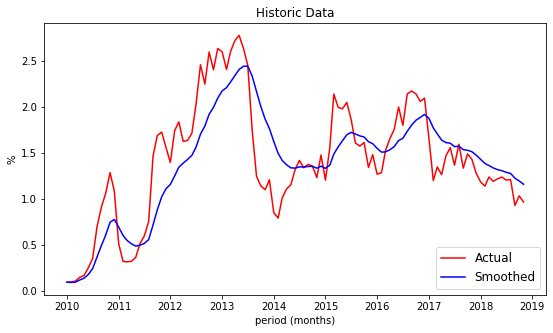

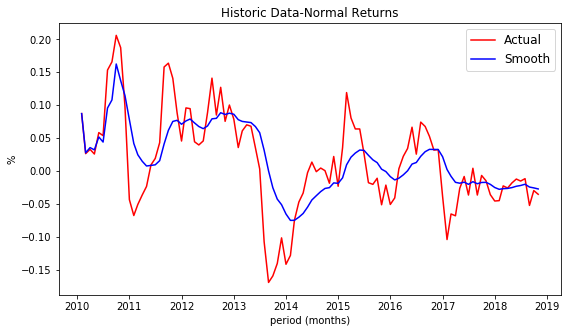

In [18]:
                        df_cpr=df_all[['EffDt','PoolNum','State','cpr']]
                        df_cpr.index=df_cpr['EffDt']
                        df_cpr=df_cpr.drop(['EffDt'],axis=1)
                        df_cpr=df_cpr.fillna(method='pad', axis=0)
                        df_cpr['cpr_ewm'] =  df_cpr.groupby(['PoolNum','State'])['cpr'].transform(lambda x: x.ewm(span=12).mean())
                        # =============================================================================
                        # Calculate Normal Returns
                        # =============================================================================
                        df_cpr['cpr_rtn'] =df_cpr.groupby(['PoolNum','State']).cpr_ewm.transform(lambda x: x.diff())
                        df_cpr['cpr_rtn_ewm'] =  df_cpr.groupby(['PoolNum','State'])['cpr_rtn'].transform(lambda x: x.ewm(span=12).mean())
                        # =============================================================================
                        # Summarize
                        # =============================================================================
                        df_cpr=df_cpr.fillna(method='pad', axis=0)
                        df_cpr_summary=df_cpr.groupby('EffDt')['cpr','cpr_ewm','cpr_rtn','cpr_rtn_ewm'].mean()
                        # =============================================================================
                        #Plot data
                        # =============================================================================  
                        
                        #Data
                        fig = plt.figure() 
                        plt.plot(df_cpr_summary['cpr'],color="r", label='Actual')
                        plt.plot(df_cpr_summary['cpr_ewm'],color="b", label='Smoothed')
                        plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Historic Data'),plt.legend(loc='lower right',fontsize=12)
                        plt.savefig('CPR Smoothing_'+ Year +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                        plt.show()
                        plt.close(fig)
                        
                        #Normal Returns
                        fig = plt.figure() 
                        plt.plot(df_cpr_summary['cpr_rtn'],color="r", label='Actual')
                        plt.plot(df_cpr_summary['cpr_rtn_ewm'],color="b", label='Smooth')
                        plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Historic Data-Normal Returns'),plt.legend(loc='upper right',fontsize=12)
                        plt.savefig('CPR Smoothing Rtns_'+ Year +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                        plt.show()
                        plt.close(fig) 
                        

## Merge Economic predictors, additional predictors and prepayment data

In [0]:
                    # =============================================================================
                    # Merge Files                        
                    # =============================================================================
                    df_merge=df_cpr.merge(df_econ_pca_std,left_on=['EffDt'],right_on=['EffDt'],how='inner')
                    df_merge=df_merge.merge(df_econ_rtn_pca_std,left_on=['EffDt'],right_on=['EffDt'],how='inner')
                    df_merge=df_merge.merge(df_econ_logrtn_pca_std,left_on=['EffDt'],right_on=['EffDt'],how='inner')
                    df_merge=df_merge.merge(df_state_econ_std,left_on=['EffDt','State'],right_on=['EffDt','State'],how='inner')
                    df_merge=df_merge.merge(df_state_econ_rtn_std,left_on=['EffDt','State'],right_on=['EffDt','State'],how='inner')
                    df_merge=df_merge.merge(df_state_econ_logrtn_std,left_on=['EffDt','State'],right_on=['EffDt','State'],how='inner')
                    df_merge=df_merge.merge(df_PoolStats,left_on=['EffDt','PoolNum','State'],right_on=['EffDt','PoolNum','State'],how='inner')
                    df_merge=df_merge.merge(df_calcpredict_std,left_on=['EffDt','PoolNum','State'],right_on=['EffDt','PoolNum','State'],how='inner')
                    df_merge=df_merge.fillna(method='pad')

## Ignore first 18 months ( Seasoning)

In [20]:
                    start_date=datetime.strptime(Year+'-01-01', '%Y-%M-%d')+ relativedelta(months=18)
                    df_merge_seasoned=df_merge.loc[start_date:end_date]
                    df_merge_seasoned.to_csv('Model Data')
                    df_merge_seasoned=df_merge_seasoned.reset_index()
                    df_Labels=df_merge_seasoned[['EffDt','PoolNum']]
                    df_Resp=df_merge_seasoned['cpr_ewm']
                    df_Resp_rtn=df_merge_seasoned['cpr_rtn_ewm']
                    #df_merge_seasoned = pd.get_dummies( df_merge_seasoned, columns = ['PoolNum','State'] )
                    #df_Input=df_merge_seasoned.drop(['EffDt','cpr','cpr_rtn'],axis=1)
                    df_Input=df_merge_seasoned.drop(['PoolNum','State','EffDt','cpr','cpr_ewm','cpr_rtn','cpr_rtn_ewm'],axis=1)
                    df_Input.to_csv('Input')
                    df_Resp.to_csv('Resp')
                    df_Resp_rtn.to_csv('Resp_rtn')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  del sys.path[0]


## Split data into Training and validation set

In [0]:
                    # =============================================================================
                    # #Split Data into Train and Test portions
                    # =============================================================================
                    df_Resp=df_Resp.to_frame()
                    df_Resp_rtn=df_Resp_rtn.to_frame()
                    TrainTestSplit=4
                    tscv = TimeSeriesSplit(n_splits=TrainTestSplit)
                        
                    for train_index, test_index in tscv.split(df_Input):
                        Input_train, Input_test = df_Input.loc[train_index], df_Input.loc[test_index]
                        Resp_train, Resp_test = df_Resp.loc[train_index], df_Resp.loc[test_index]
                        Resp_rtn_train, Resp_rtn_test = df_Resp_rtn.loc[train_index], df_Resp_rtn.loc[test_index] 
                        Labels_train, Labels_test = df_Labels.loc[train_index], df_Labels.loc[test_index]
                           

# Build Neural Net

In [22]:
                    # ===============================================================================================================================
                    # Key Neural Net Drivers
                    # ===============================================================================================================================
                    L2Reg=0.0002
                    Dropout=0.20
                    LR=0.00002
                    LR_Decay=0.0001
                    Loss='mse'
                    
                     #===============================================================================================================================
                    # Define Optimizers
                    #===============================================================================================================================
                    OptMdl=keras.optimizers.Adam(lr=LR, beta_1=0.9, beta_2=0.999, epsilon=None, decay=LR_Decay, amsgrad=False)     
                    #================================================================================================================================
                    #Define and build Model
                    #================================================================================================================================
                    def build_Mdl():
                        Mdl = keras.Sequential([
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1024,kernel_regularizer=keras.regularizers.l2(L2Reg), activation=tf.nn.relu,input_shape=(Input_train.shape[1],)),
                        keras.layers.Dropout(Dropout),
                        keras.layers.Dense(1)
                        ])    
                        Mdl.compile(optimizer=OptMdl,loss=Loss, metrics=['accuracy',Loss])
                        return Mdl   
                    Mdl = build_Mdl()
                        # =============================================================================
                        # Display training progress by printing a single dot for each completed epoch
                        # =============================================================================
                    class PrintDot(keras.callbacks.Callback):
                        def on_epoch_end(self, epoch, logs):
                            if epoch % 100 == 0: print('')
                            print('.', end='')      

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## SMM Calibration

### Fit Model

In [23]:
                    
                    early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-9, patience=20)
                    model_checkpoint= keras.callbacks.ModelCheckpoint(filepath='FNMAPrepay_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit+'.h5', monitor='val_loss', mode='min', verbose=1)
                    Calib = Mdl.fit(Input_train, Resp_train, epochs=5,verbose=1,batch_size=128,validation_data=(Input_test, Resp_test),callbacks=[early_stop,model_checkpoint, PrintDot()])

Train on 66170 samples, validate on 16542 samples
Epoch 1/5
65408/66170 [============================>.] - ETA: 0s - loss: 2.3220 - acc: 0.0000e+00 - mean_squared_error: 0.5429
Epoch 00001: saving model to FNMAPrepay_2010_All_50_All_All_All.h5

66170/66170 [==============================] - 8s 120us/sample - loss: 2.3176 - acc: 0.0000e+00 - mean_squared_error: 0.5394 - val_loss: 1.9296 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.2272
Epoch 2/5
65920/66170 [============================>.] - ETA: 0s - loss: 1.8769 - acc: 0.0000e+00 - mean_squared_error: 0.2415
Epoch 00002: saving model to FNMAPrepay_2010_All_50_All_All_All.h5
66170/66170 [==============================] - 5s 80us/sample - loss: 1.8767 - acc: 0.0000e+00 - mean_squared_error: 0.2415 - val_loss: 1.8396 - val_acc: 0.0000e+00 - val_mean_squared_error: 0.2681
Epoch 3/5
65920/66170 [============================>.] - ETA: 0s - loss: 1.7238 - acc: 0.0000e+00 - mean_squared_error: 0.2087
Epoch 00003: saving model to FNMAPrep

### Collate results and display graphs

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


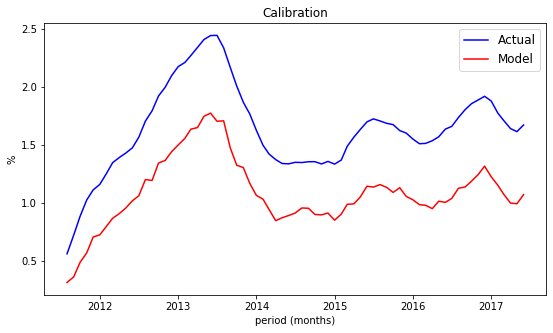

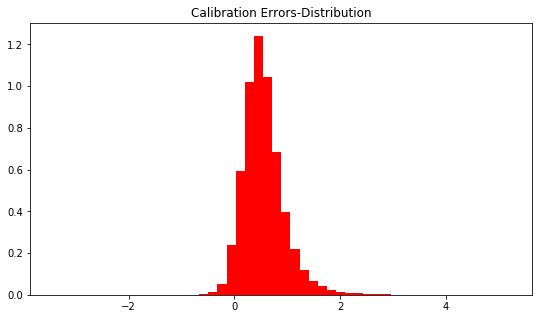

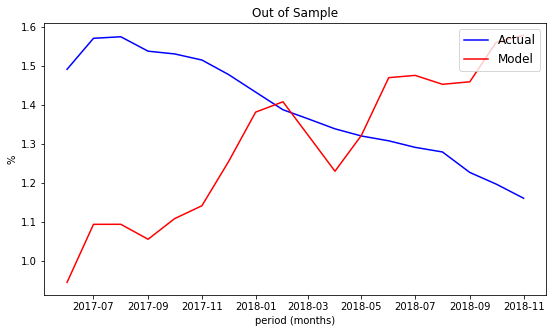

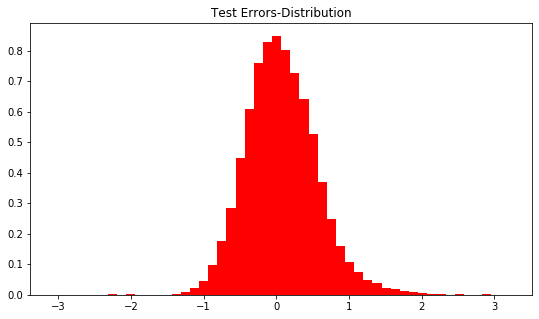

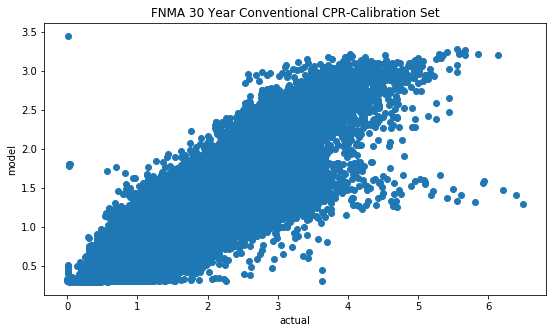

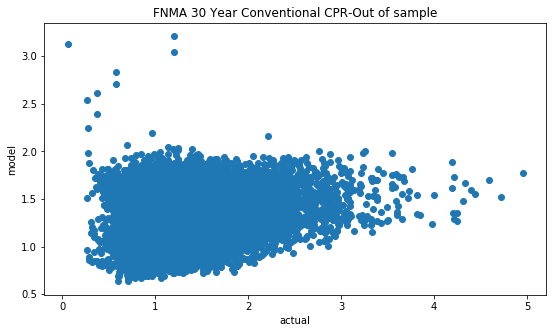

In [24]:
                    BestModel = keras.models.load_model('FNMAPrepay_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit+'.h5')                
                    # ==============================================================================================================================================================================================
                    #Summarise Results
                    # ==============================================================================================================================================================================================
                    #Calibration Set
                    Mdl_train=pd.DataFrame(BestModel.predict(Input_train).flatten(),columns=['cpr'])
                    Mdl_train['Actual']=Resp_train['cpr_ewm']
                    Mdl_train.insert(loc=0, column='PoolNum', value=Labels_train['PoolNum'].values)
                    Mdl_train.insert(loc=0, column='EffDt', value=Labels_train['EffDt'].values)
                    Mdl_train['Errors']=Mdl_train['Actual']-Mdl_train['cpr']
                    Mdl_train_summary=Mdl_train.groupby('EffDt')['cpr','Actual','Errors'].mean()
                        
                    #out of Sample                 
                    Mdl_test=pd.DataFrame(BestModel.predict(Input_test).flatten(),columns=['cpr'])
                    Resp_test_reindex=Resp_test.reset_index()
                    Mdl_test['Actual']=Resp_test_reindex['cpr_ewm']
                    Mdl_test.insert(loc=0, column='PoolNum', value=Labels_test['PoolNum'].values)
                    Mdl_test.insert(loc=0, column='EffDt', value=Labels_test['EffDt'].values)
                    Mdl_test['Errors']=Mdl_test['Actual']-Mdl_test['cpr']
                    Mdl_test_summary=Mdl_test.groupby('EffDt')['cpr','Actual','Errors'].mean()
                       
                    # All history 
                    Mdl_all=pd.DataFrame(BestModel.predict(df_Input).flatten(),columns=['cpr'])
                    Mdl_all['Actual']=df_Resp['cpr_ewm']
                    Mdl_all.insert(loc=0, column='PoolNum', value=df_Labels['PoolNum'].values)
                    Mdl_all.insert(loc=0, column='EffDt', value=df_Labels['EffDt'].values)
                    Mdl_all['Errors']=Mdl_all['Actual']-Mdl_all['cpr']
                    Mdl_all_summary=Mdl_all.groupby('EffDt')['cpr','Actual','Errors'].mean()                          
                    # ============================================================================================================================================================================================
                    # Plot Results
                    # ============================================================================================================================================================================================                                         
                    fig = plt.figure() 
                    plt.plot(Mdl_train_summary['Actual'],color="b", label='Actual')
                    plt.plot(Mdl_train_summary['cpr'],color="r", label='Model')
                    plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Calibration'),plt.legend(loc='upper right',fontsize=12)
                    plt.savefig('ModelResults_train_'+ Year +'_'+ OLTV +'_'+ Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                           
                    fig = plt.figure() 
                    plt.hist(Mdl_train['Errors'],bins=50,density=True,color="r", label='error')
                    plt.savefig('ModelResultsModelResults_train_error_'+ Year +'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.title('Calibration Errors-Distribution')
                    plt.show()
                    plt.close(fig)
                                       
                    fig = plt.figure() 
                    plt.plot(Mdl_test_summary['Actual'],color="b", label='Actual')
                    plt.plot(Mdl_test_summary['cpr'],color="r", label='Model')
                    plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Out of Sample'),plt.legend(loc='upper right',fontsize=12)
                    plt.savefig('ModelResults_test_'+ Year +'_'+ OLTV+'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                        
                    fig = plt.figure() 
                    plt.hist(Mdl_test['Errors'],bins=50,density=True,color="r", label='error')
                    plt.savefig('ModelResults_train_error_'+ Year +'_'+ OLTV+ '_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.title('Test Errors-Distribution')
                    plt.show()
                    plt.close(fig)
                    # ====================================================================================================================================================================================
                    # Scatter Plots
                    # ====================================================================================================================================================================================                                               
                    fig = plt.figure() 
                    plt.scatter(Mdl_train['Actual'],Mdl_train['cpr'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR-Calibration Set")
                    plt.savefig('FNMATrain_Fit_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig) 
        
                    fig = plt.figure() 
                    plt.scatter(Mdl_test['Actual'],Mdl_test['cpr'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR-Out of sample")
                    plt.savefig('FNMATest_Fit_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)                   
    

## SMM Normal returns

### Fit Model

In [0]:
                    early_stop_rtn = keras.callbacks.EarlyStopping(monitor='val_loss',min_delta=1e-9, patience=20)
                    model_checkpoint_rtn= keras.callbacks.ModelCheckpoint(filepath='FNMAPrepay_rtn_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit+'.h5', monitor='val_loss', mode='min', verbose=1)
                    Calib_Rtn = Mdl.fit(Input_train, Resp_rtn_train, epochs=5,verbose=1,batch_size=128,validation_data=(Input_test, Resp_rtn_test),callbacks=[early_stop_rtn,model_checkpoint_rtn, PrintDot()])

ValueError: ignored

### Collate Results and display graphs

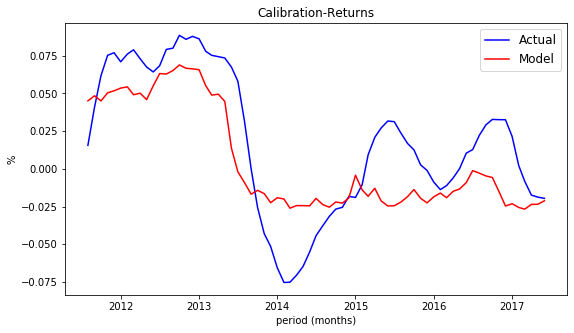

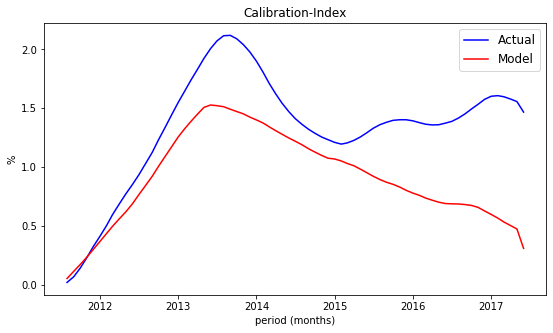

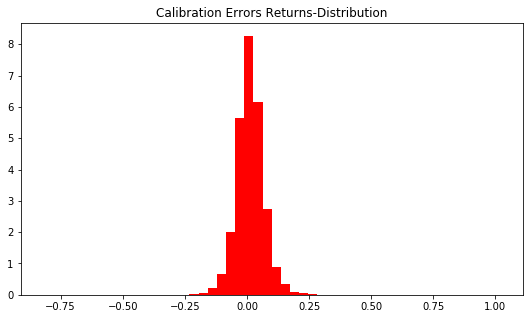

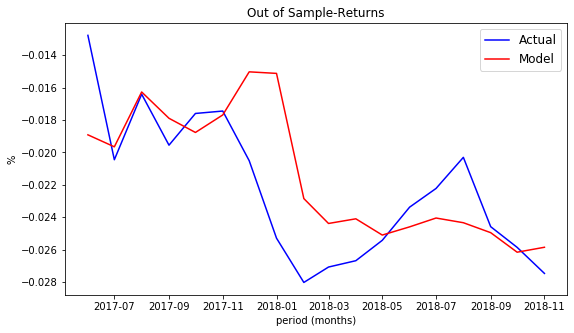

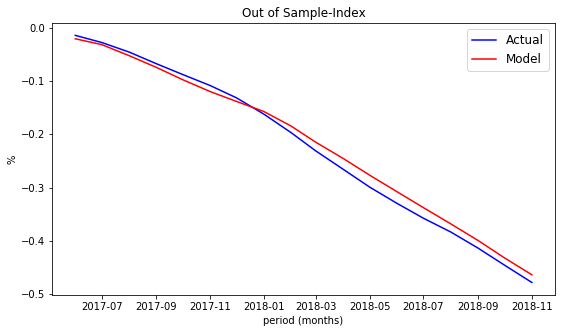

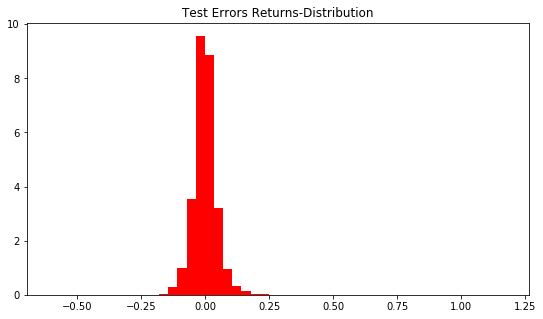

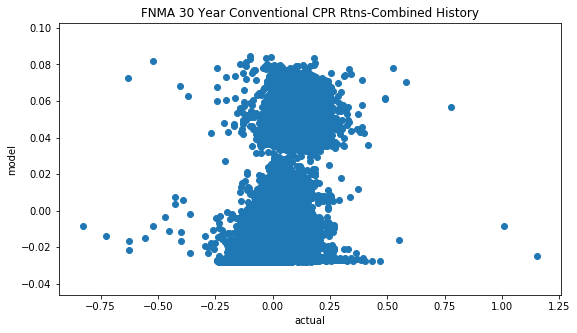

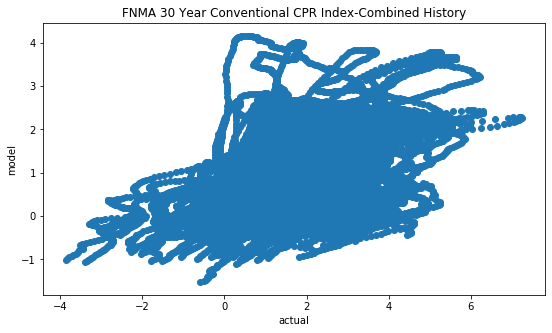

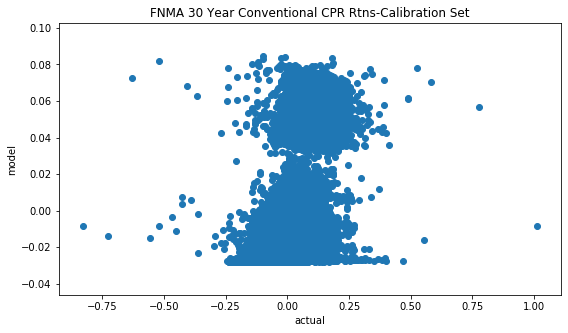

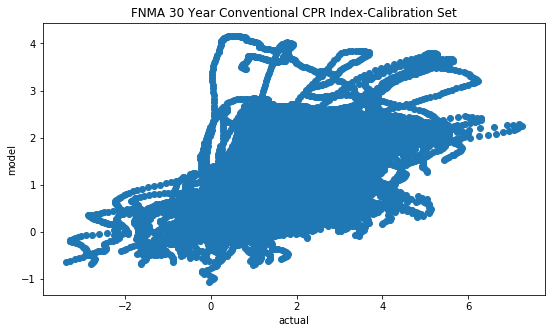

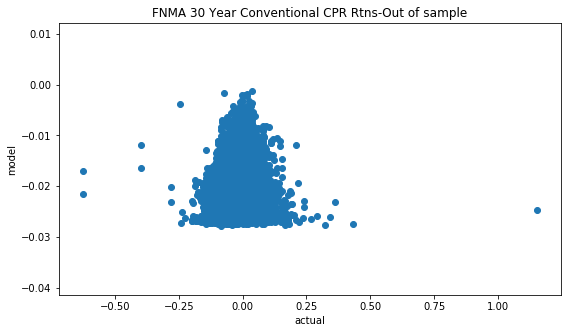

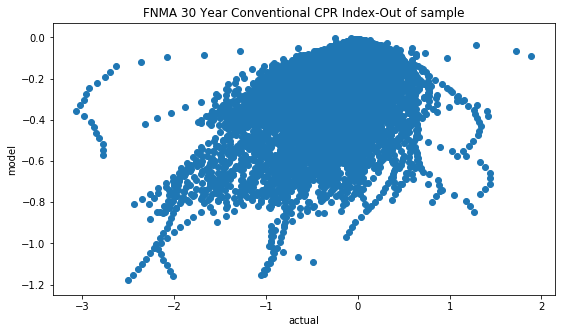

In [0]:
                    BestModel_rtn = keras.models.load_model('FNMAPrepay_rtn_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit+'.h5') 
                    # ==============================================================================================================================================================================================
                    #Summarise Results(Rtns)
                    # ==============================================================================================================================================================================================
                    #Calibration Set
                    Mdl_rtn_train=pd.DataFrame(BestModel_rtn.predict(Input_train).flatten(),columns=['cpr_rtn'])
                    Mdl_rtn_train.insert(loc=0, column='PoolNum', value=Labels_train['PoolNum'].values)
                    Mdl_rtn_train.insert(loc=0, column='EffDt', value=Labels_train['EffDt'].values)
                    Mdl_rtn_train['cpr_indx'] = Mdl_rtn_train.groupby(['PoolNum']).cpr_rtn.transform(lambda x: np.cumsum(x))
                    Mdl_rtn_train['actual_rtn']=Resp_rtn_train['cpr_rtn_ewm']
                    Mdl_rtn_train['actual_indx'] = Mdl_rtn_train.groupby(['PoolNum']).actual_rtn.transform(lambda x: np.cumsum(x))
                    Mdl_rtn_train['Errors_rtn']=Mdl_rtn_train['actual_rtn']-Mdl_rtn_train['cpr_rtn']
                    Mdl_rtn_train['Errors_indx']=Mdl_rtn_train['actual_indx']-Mdl_rtn_train['cpr_indx']
                    Mdl_rtn_train_summary=Mdl_rtn_train.groupby('EffDt')['cpr_rtn','cpr_indx','actual_indx','actual_rtn','Errors_indx','Errors_rtn'].mean()
                    #Out of Sample Set
                    Resp_rtn_test=Resp_rtn_test.reset_index()
                    Mdl_rtn_test=pd.DataFrame(BestModel_rtn.predict(Input_test).flatten(),columns=['cpr_rtn'])
                    Mdl_rtn_test.insert(loc=0, column='PoolNum', value=Labels_test['PoolNum'].values)
                    Mdl_rtn_test.insert(loc=0, column='EffDt', value=Labels_test['EffDt'].values)
                    Mdl_rtn_test['cpr_indx'] = Mdl_rtn_test.groupby(['PoolNum']).cpr_rtn.transform(lambda x: np.cumsum(x))
                    Mdl_rtn_test['actual_rtn']=Resp_rtn_test['cpr_rtn_ewm']
                    Mdl_rtn_test['actual_indx'] =Mdl_rtn_test.groupby(['PoolNum']).actual_rtn.transform(lambda x: np.cumsum(x))
                    Mdl_rtn_test['Errors_rtn']=Mdl_rtn_test['actual_rtn']-Mdl_rtn_test['cpr_rtn']
                    Mdl_rtn_test['Errors_indx']=Mdl_rtn_test['actual_indx']-Mdl_rtn_test['cpr_indx']
                    Mdl_rtn_test_summary=Mdl_rtn_test.groupby('EffDt')['cpr_rtn','cpr_indx','actual_indx','actual_rtn','Errors_indx','Errors_rtn'].mean()
                    # All history 
                    Mdl_rtn_all=pd.DataFrame(BestModel_rtn.predict(df_Input).flatten(),columns=['cpr_rtn'])
                    Mdl_rtn_all.insert(loc=0, column='PoolNum', value=df_Labels['PoolNum'].values)
                    Mdl_rtn_all.insert(loc=0, column='EffDt', value=df_Labels['EffDt'].values)
                    Mdl_rtn_all['cpr_indx'] = Mdl_rtn_all.groupby(['PoolNum']).cpr_rtn.transform(lambda x: np.cumsum(x))
                    Mdl_rtn_all['actual_rtn']=df_Resp_rtn['cpr_rtn_ewm']
                    Mdl_rtn_all['actual_indx']=Mdl_rtn_all.groupby(['PoolNum']).actual_rtn.transform(lambda x: np.cumsum(x))
                    Mdl_rtn_all['Errors_rtn']=Mdl_rtn_all['actual_rtn']-Mdl_rtn_all['cpr_rtn']
                    Mdl_rtn_all['Errors_indx']=Mdl_rtn_all['actual_indx']-Mdl_rtn_all['cpr_indx']
                    Mdl_rtn_all_summary=Mdl_rtn_all.groupby('EffDt')['cpr_rtn','cpr_indx','actual_indx','actual_rtn','Errors_indx','Errors_rtn'].mean()    
                    # ============================================================================================================================================================================================
                    # Plot Results (Rtns)
                    # ============================================================================================================================================================================================                                            
                    fig = plt.figure() 
                    plt.plot(Mdl_rtn_train_summary['actual_rtn'],color="b", label='Actual')
                    plt.plot(Mdl_rtn_train_summary['cpr_rtn'],color="r", label='Model')
                    plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Calibration-Returns'),plt.legend(loc='upper right',fontsize=12)
                    plt.savefig('ModelResults_train_rtn_'+ Year +'_'+ OLTV + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig) 
                    
                    fig = plt.figure() 
                    plt.plot(Mdl_rtn_train_summary['actual_indx'],color="b", label='Actual')
                    plt.plot(Mdl_rtn_train_summary['cpr_indx'],color="r", label='Model')
                    plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Calibration-Index'),plt.legend(loc='upper right',fontsize=12)
                    plt.savefig('ModelResults_train_rtn_indx_'+ Year +'_'+ OLTV + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)  
                        
                    fig = plt.figure() 
                    plt.hist(Mdl_rtn_train['Errors_rtn'],bins=50,density=True,color="r", label='error')
                    plt.savefig('ModelResults_train_error_'+ Year +'_'+ OLTV + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.title('Calibration Errors Returns-Distribution')
                    plt.show()
                    plt.close(fig)

                    fig = plt.figure() 
                    plt.plot(Mdl_rtn_test_summary['actual_rtn'],color="b", label='Actual')
                    plt.plot(Mdl_rtn_test_summary['cpr_rtn'],color="r", label='Model')
                    plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Out of Sample-Returns'),plt.legend(loc='upper right',fontsize=12)
                    plt.savefig('ModelResults_test_rtn'+ Year +'_'+ OLTV+'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                    
                    fig = plt.figure() 
                    plt.plot(Mdl_rtn_test_summary['actual_indx'],color="b", label='Actual')
                    plt.plot(Mdl_rtn_test_summary['cpr_indx'],color="r", label='Model')
                    plt.xlabel('period (months)'),plt.ylabel('%'),plt.title('Out of Sample-Index'),plt.legend(loc='upper right',fontsize=12)
                    plt.savefig('ModelResults_test_indx'+ Year +'_'+ OLTV+'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                                              
                    fig = plt.figure() 
                    plt.hist(Mdl_rtn_test['Errors_rtn'],bins=50,density=True,color="r", label='error')
                    plt.savefig('ModelResults_train_rtn_error_'+ Year +'_'+ OLTV+ '_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.title('Test Errors Returns-Distribution')
                    plt.show()
                    plt.close(fig)  
                    # ====================================================================================================================================================================================
                    # Scatter Plots (Rtns)
                    # ====================================================================================================================================================================================                  
                    fig = plt.figure() 
                    plt.scatter(Mdl_rtn_all['actual_rtn'],Mdl_rtn_all['cpr_rtn'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR Rtns-Combined History")
                    plt.savefig('FNMAAll_Fit_rtn_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                        
                    fig = plt.figure() 
                    plt.scatter(Mdl_rtn_all['actual_indx'],Mdl_rtn_all['cpr_indx'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR Index-Combined History")
                    plt.savefig('FNMAAll_Fit_Indx_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                        
                    fig = plt.figure() 
                    plt.scatter(Mdl_rtn_train['actual_rtn'],Mdl_rtn_train['cpr_rtn'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR Rtns-Calibration Set")
                    plt.savefig('FNMATrain_Fit_rtn_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig) 
                        
                    fig = plt.figure() 
                    plt.scatter(Mdl_rtn_train['actual_indx'],Mdl_rtn_train['cpr_indx'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR Index-Calibration Set")
                    plt.savefig('FNMATrain_Fit_Indx_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
        
                    fig = plt.figure() 
                    plt.scatter(Mdl_rtn_test['actual_rtn'],Mdl_rtn_test['cpr_rtn'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR Rtns-Out of sample")
                    plt.savefig('FNMATest_Fit_rtn_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig)
                        
                    fig = plt.figure() 
                    plt.scatter(Mdl_rtn_test['actual_indx'],Mdl_rtn_test['cpr_indx'])
                    plt.xlabel('actual')
                    plt.ylabel('model')
                    plt.title("FNMA 30 Year Conventional CPR Index-Out of sample")
                    plt.savefig('FNMATest_Fit_indx_'+ Year+'_'+ OLTV +'_' + Rate+ '_' + Purch+ '_' + Owner + '_' + SingUnit)
                    plt.show()
                    plt.close(fig) 